**Setup & Initial Data Exploration**

In [1]:
# Import Numpy and Datascience modules
import numpy as np
from datascience import *

# Import plotting tools
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

The following cells read in the data, join them to create a single table, and calculate the metrics that I was curious about that weren't already presented in the dataset

In [2]:
# Read in data
arrests = Table.read_table('police-arrests.csv')
acct = Table.read_table('police-accountability.csv')
demo = Table.read_table('police-demographic.csv')


In [3]:
# Create column for average score across accountability metrics in acct
a = np.zeros(157)

for i in np.arange(3, 9): 
    a = a + 1 - acct.column(i)

for i in np.arange(9, 17):
    a = a + acct.column(i)

acct_score = a/14

acct = acct.with_column('Average Score on 14 Accountability Metrics', acct_score)

In [4]:
# Join tables into a single table
all = arrests.join('Agency Name', acct, 'Agency Name').join('Agency Name', demo, 'Agency Name').drop('Type of Agency_2').drop('Type of Agency_3').drop('County_2').drop('County_3')
all = all.relabeled('White Population', 'Hispanic Population mod').relabeled('Black Population', 'White Population').relabeled('Hispanic Population', 'Black Population').relabeled('Hispanic Population mod', 'Hispanic Population')

In [5]:
# Create column for people killed/seriously injured normalized by jurisdiction population
all = all.with_column('People Killed or Seriously Injured by Police, 2016-2018 norm by pop.', 
    all.column('People Killed or Seriously Injured by Police, 2016-2018')/all.column('Total Population of Jurisdiction'))

In [6]:
# Create columns for pct white, non-white, pct black, & pct hispanic population
pctwhite = all.column('White Population')/all.column('Total Population of Jurisdiction')
all = all.with_column('White Percent of Population', pctwhite)
pctnonwhite = 1 - all.column('White Population')/all.column('Total Population of Jurisdiction')
all = all.with_column('Pct Non-white', pctnonwhite)
pctblack = all.column('Black Population')/all.column('Total Population of Jurisdiction')
all = all.with_column('Black Percent of Population', pctblack)
pcthispanic = all.column('Hispanic Population')/all.column('Total Population of Jurisdiction')
all = all.with_column('Pct Hispanic', pcthispanic)
pctblackorhispanic = (all.column('Hispanic Population')+all.column('Black Population'))/all.column('Total Population of Jurisdiction')
all = all.with_column('Pct Black & Hispanic', pctblackorhispanic)
all = all.with_column('Majority Black & Hispanic', pctblackorhispanic>0.5)
all = all.with_column('Majority Black', pctblack>0.5)
all = all.with_column('Majority Hispanic', pcthispanic>0.5)
all = all.with_column('Majority White', pctwhite>0.5)
pctasian = all.column('Asian Population')/all.column('Total Population of Jurisdiction')
all = all.with_column('Pct Asian', pctasian)
all = all.with_column('Majority Asian', pctasian>0.5)


# Create columns for pct drug arrests by race
alldrugarrests = all.column(20)+all.column(21)+all.column(22)+all.column(23)+all.column(24)+all.column(25)
all = all.with_column('All Drug Arrests', alldrugarrests)
all = all.with_column('Drug Arrest Rate (Arrests/Person)', alldrugarrests/all.column('Total Population of Jurisdiction'))
all = all.with_column('White Percent of Drug Arrests', all.column('White Drug Possession Arrests, 2016')/alldrugarrests)
all = all.with_column('Non-White Percent of Drug Arrests', 1 - all.column('White Percent of Drug Arrests'))
all = all.with_column('Black Percent of Drug Arrests', all.column('Black Drug Possession Arrests, 2016')/alldrugarrests)
all = all.with_column('Hispanic Percent of Drug Arrests',all.column('Hispanic Drug Possession Arrests, 2016')/alldrugarrests)

# Create column for police budget
all = all.with_column('Police Budget', 10**all.column('Log of Police Budget'))

# Create new column that converts the police budget proportion to a percentage (i.e., multiply by 100%)
pb_pct = all.column('percent_police_budget')*100
all = all.with_column('Police Budget % Total Budget', pb_pct)

In [7]:
# Create column listing population racial majority group
majority_all = []

for i in np.arange(all.num_rows):
    if all.column('Majority Black')[i] == True: 
        majority_all.append('Majority Black')
    else:
        if all.column('Majority Hispanic')[i]==True:
            majority_all.append('Majority Hispanic')
        else:
            if all.column('Majority Asian')[i]==True:
                majority_all.append('Majority Asian')
            else:
                if all.column('Majority White')[i]==True:
                    majority_all.append('Majority White')
                else: 
                    majority_all.append('No Majority')
all = all.with_column('Population Racial Majority', majority_all)

In [8]:
all.select('Population Racial Majority').group(0)

Population Racial Majority,count
Majority Asian,4
Majority Hispanic,28
Majority White,70
No Majority,55


In [9]:
# Create column listing population racial majority groups used for A/B test
majority = []

for i in np.arange(all.num_rows):
    if all.column('Majority Black & Hispanic')[i] == True: 
        majority.append('Majority Black & Hispanic')
    else:
        if all.column('Majority White')[i]==True:
            majority.append('Majority White')
        else:
            majority.append('Neither')
all = all.with_column('Population Majority Black & Hispanic, White, or Neither', majority)

In [10]:
all.select('Population Majority Black & Hispanic, White, or Neither').group(0)

"Population Majority Black & Hispanic, White, or Neither",count
Majority Black & Hispanic,43
Majority White,70
Neither,44


In [11]:
all.sort('Black Percent of Population', descending = True)

Agency Name,Type of Agency,County,Region,Overall Score,Police Violence Score,Police Accountability Score,Approach to Policing Score,"People Killed or Seriously Injured by Police, 2016-2018",Percent who Did Not Reportedly Have a Gun,Percent Who were Confirmed Unarmed,People Deadly Force Used Against Who were Perceived to Have a Gun,People Deadly Force Used Against Who were Confirmed with a Gun,2016 Police Shootings,2017 Police Shootings,2018 Police Shootings,"Total Arrests, 2016-2018",Homicides (2013-2018),percent_police_budget,Log of Police Budget,"Asian/Pacific Islander Drug Possession Arrests, 2016","Black Drug Possession Arrests, 2016","Hispanic Drug Possession Arrests, 2016","Unknown Race Drug Possession Arrests, 2016","Other Race Drug Possession Arrests, 2016","White Drug Possession Arrests, 2016",disqualifies_complaints,restricts_delays_interrogations,gives_officers_unfair_access_to_information,limits_oversight_discipline,requires_city_pay_for_misconduct,erases_misconduct_records,requires_deescalation,bans_chokeholds_and_strangleholds,duty_to_intervene,requires_warning_before_shooting,restricts_shooting_at_moving_vehicles,requires_comprehensive_reporting,requires_exhaust_all_other_means_before_shooting,has_use_of_force_continuum,Average Score on 14 Accountability Metrics,Total Population of Jurisdiction,Hispanic Population,White Population,Black Population,Native American Population,Asian Population,Pacific Islander Population,Other Population,Multiracial Population,Percent High School Graduates in Jurisdiction,Unemployment Rate in Jurisdiction,Median Income,Poverty Rate,"People Killed or Seriously Injured by Police, 2016-2018 norm by pop.",White Percent of Population,Pct Non-white,Black Percent of Population,Pct Hispanic,Pct Black & Hispanic,Majority Black & Hispanic,Majority Black,Majority Hispanic,Majority White,Pct Asian,Majority Asian,All Drug Arrests,Drug Arrest Rate (Arrests/Person),White Percent of Drug Arrests,Non-White Percent of Drug Arrests,Black Percent of Drug Arrests,Hispanic Percent of Drug Arrests,Police Budget,Police Budget % Total Budget,Population Racial Majority,"Population Majority Black & Hispanic, White, or Neither"
Inglewood Police Department,Police Department,Los Angeles County,Southern,0.59,0.65,0.49,0.64,3,0,0,3,3,1,0,1,4157,85,0.247287,7.799,1,32,39,0,0,5,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0.357143,113277,58391,4413,45887,0,1588,283,367,2348,72.9,10.7,39530,24.7,2.64838e-05,0.0389576,0.961042,0.405087,0.515471,0.920558,True,False,True,False,0.0140187,False,77,0.00067975,0.0649351,0.935065,0.415584,0.506494,6.29505e+07,24.7287,Majority Hispanic,Majority Black & Hispanic
Oakland Police Department,Police Department,Alameda County,Northern,0.58,0.74,0.41,0.6,3,0.33,0.33,2,2,0,1,1,30026,479,0.181993,8.47653,15,656,145,1,9,84,1,1,1,1,1,1,1,0,1,0,0,1,1,1,0.357143,425422,114218,118302,100523,1742,65603,2515,1369,21150,81.1,6.4,57553,20.5,7.05182e-06,0.278082,0.721918,0.23629,0.268482,0.504772,True,False,False,False,0.154207,False,910,0.00213905,0.0923077,0.907692,0.720879,0.159341,2.99592e+08,18.1993,No Majority,Majority Black & Hispanic
Gardena Police Department,Police Department,Los Angeles County,Southern,0.52,0.4,0.71,0.46,5,0.6,0,3,2,0,3,3,5424,21,0.251791,7.42936,1,118,153,1,9,38,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0.357143,61033,23303,5558,14242,134,15075,146,630,1945,82.6,5.3,45200,15.7,8.19229e-05,0.0910655,0.908935,0.233349,0.38181,0.615159,True,False,False,False,0.246998,False,320,0.00524307,0.11875,0.88125,0.36875,0.478125,2.6876e+07,25.1791,No Majority,Majority Black & Hispanic
Hawthorne Police Department,Police Department,Los Angeles County,Southern,0.52,0.55,0.28,0.72,2,0.5,0.5,1,1,1,0,0,6464,30,0.36671,7.58899,3,43,114,1,7,29,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.285714,88892,50160,8394,18575,0,5806,0,423,5534,72.4,7.3,44102,21.3,2.24992e-05,0.0944292,0.905571,0.208961,0.56428,0.773242,True,False,True,False,0.0653152,False,197,0.00221617,0.147208,0.852792,0.218274,0.57868,3.8814e+07,36.671,Majority Hispanic

The following cells were used to explore police budget data

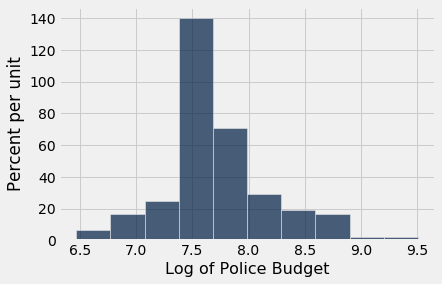

In [12]:
# Create histogram of the log of police budgets
all.hist('Log of Police Budget')

In [13]:
pb_med = np.median(all.column('Police Budget % Total Budget'))
pb_med, min(all.column('Police Budget % Total Budget')), max(all.column('Police Budget % Total Budget'))

(16.3937807, 5.0659067, 39.9341703)

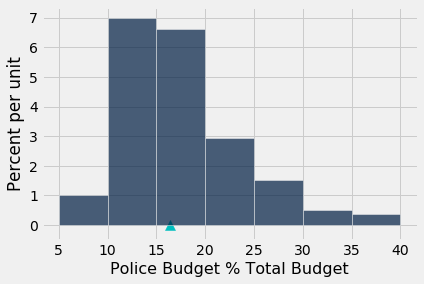

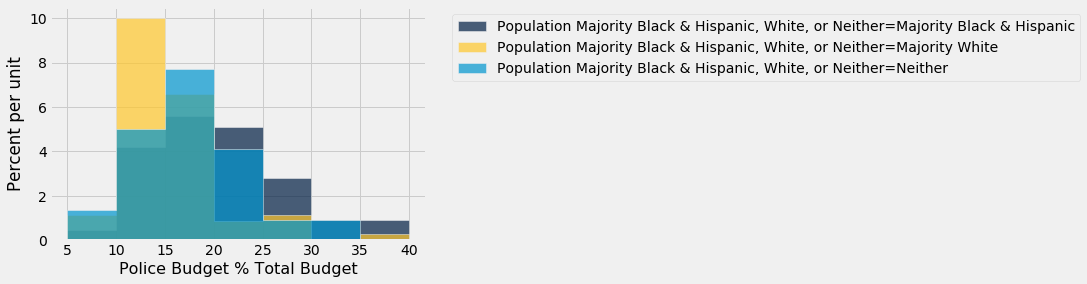

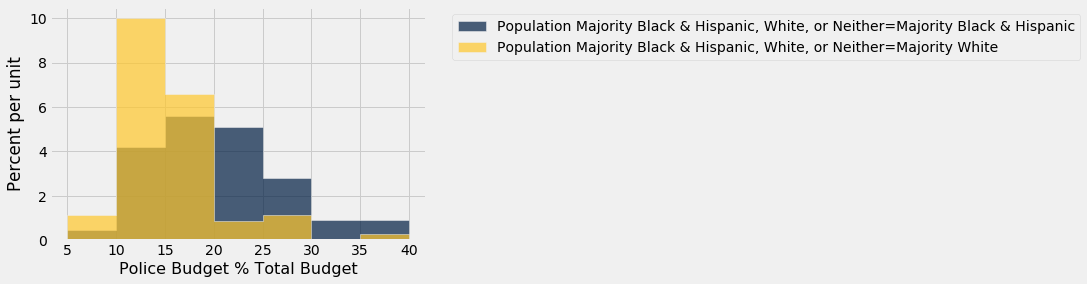

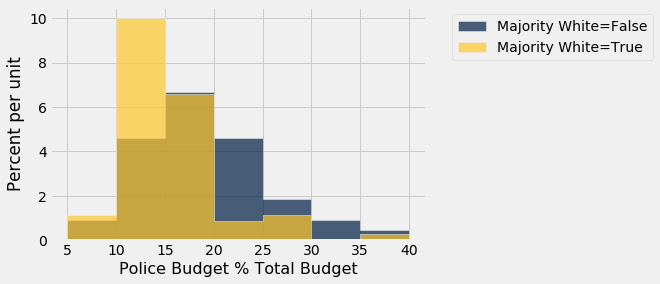

In [14]:
# Create histogram of the police budget % total budget (% of jurisdiction's budget that goes toward police)
bins = np.arange(5, 45, 5)
all.hist('Police Budget % Total Budget', bins = bins)
plt.scatter(pb_med, 0, marker='^', color='c', s=100)
#plt.title('Histogram of Police Budget as Percentage of Total Jurisdiction Budget')
all.hist('Police Budget % Total Budget', group = 'Population Majority Black & Hispanic, White, or Neither', bins = bins)
all_mod = all.where('Population Majority Black & Hispanic, White, or Neither', are.not_equal_to('Neither'))
all_mod.hist('Police Budget % Total Budget', group = 'Population Majority Black & Hispanic, White, or Neither', bins = bins)
#plt.title('Histogram of Police Budget as Percentage of Total Jurisdiction Budget by Population Majority Group')
all.hist('Police Budget % Total Budget', group = 'Majority White', bins = bins)


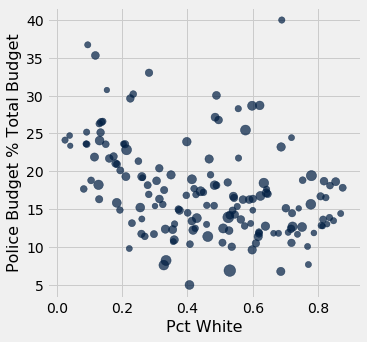

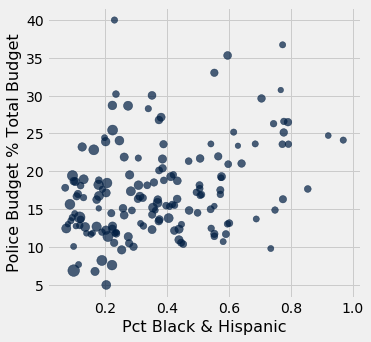

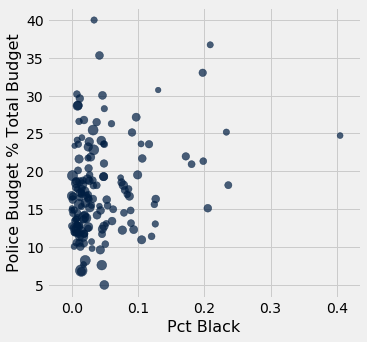

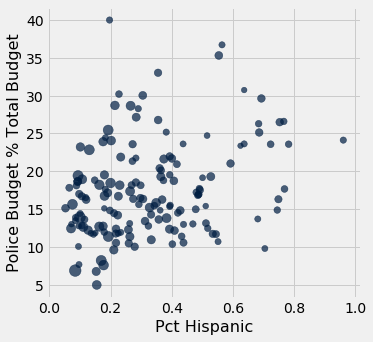

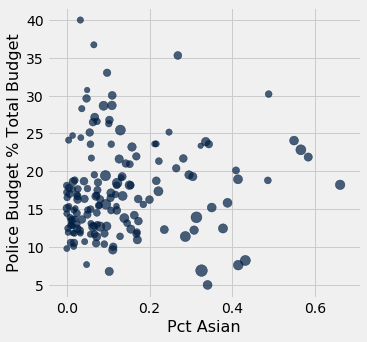

In [15]:
# Create scatterplot of police budget vs. population racial breakdown
mi = all.column('Median Income')
all.scatter('White Percent of Population', 'Police Budget % Total Budget', s = mi*.0009)
plt.xlabel('Pct White')
all.scatter('Pct Black & Hispanic', 'Police Budget % Total Budget', s = mi*.0009)
all.scatter('Black Percent of Population', 'Police Budget % Total Budget',  s = mi*.0009)
plt.xlabel('Pct Black')
all.scatter('Pct Hispanic', 'Police Budget % Total Budget', s = mi*.0009)
all.scatter('Pct Asian', 'Police Budget % Total Budget', s = mi*.0009)


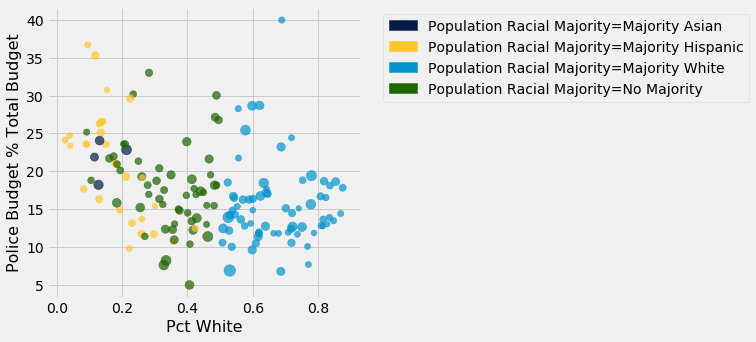

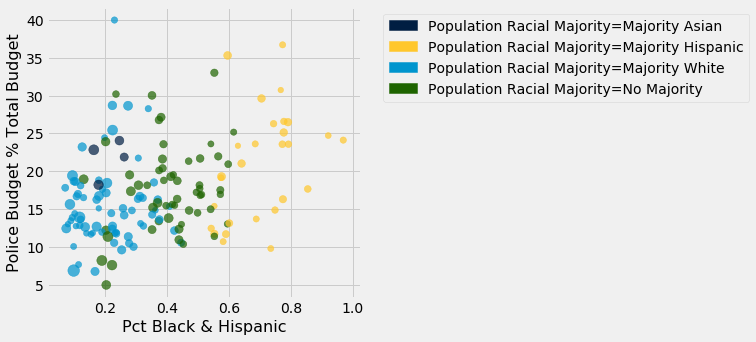

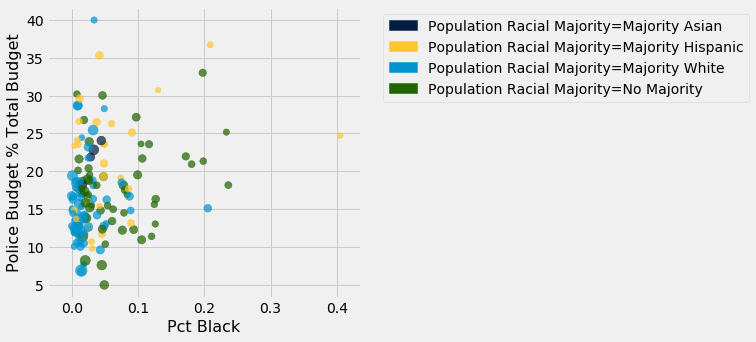

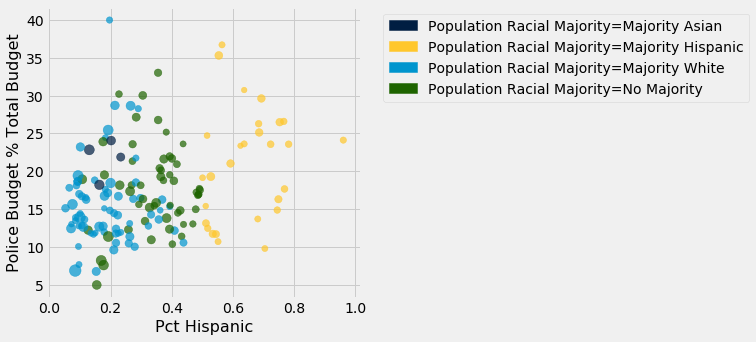

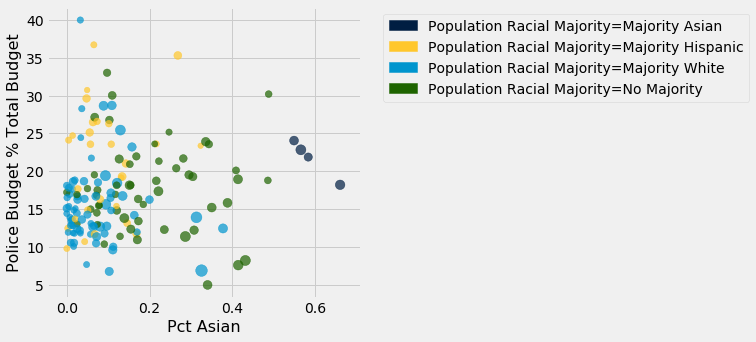

In [17]:
# Create scatterplot of police budget vs. population racial breakdown
mi = all.column('Median Income')
all.scatter('White Percent of Population', 'Police Budget % Total Budget', s = mi*.0009, colors = 'Population Racial Majority')
plt.xlabel('Pct White')
all.scatter('Pct Black & Hispanic', 'Police Budget % Total Budget', s = mi*.0009, colors = 'Population Racial Majority')
all.scatter('Black Percent of Population', 'Police Budget % Total Budget',  s = mi*.0009, colors = 'Population Racial Majority')
plt.xlabel('Pct Black')
all.scatter('Pct Hispanic', 'Police Budget % Total Budget', s = mi*.0009, colors = 'Population Racial Majority')
all.scatter('Pct Asian', 'Police Budget % Total Budget', s = mi*.0009, colors = 'Population Racial Majority')


In [ ]:
all.scatter('Drug Arrest Rate (Arrests/Person)', 'Police Budget % Total Budget', s = mi*.0009, colors = 'Population Majority Black & Hispanic, White, or Neither')


(-0.1, 1.05)

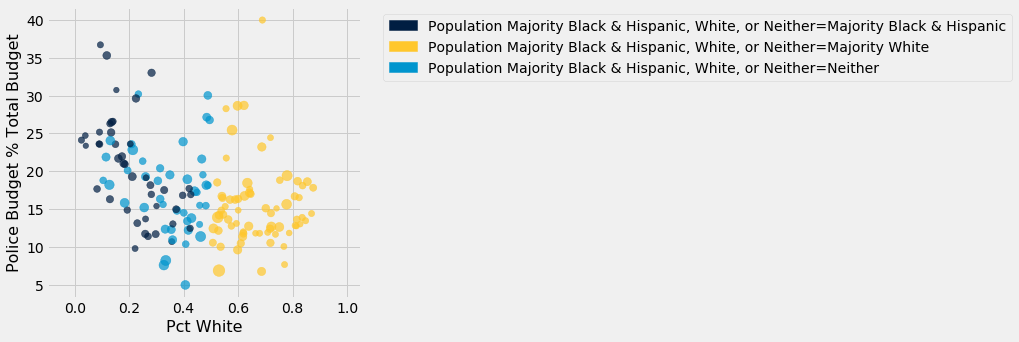

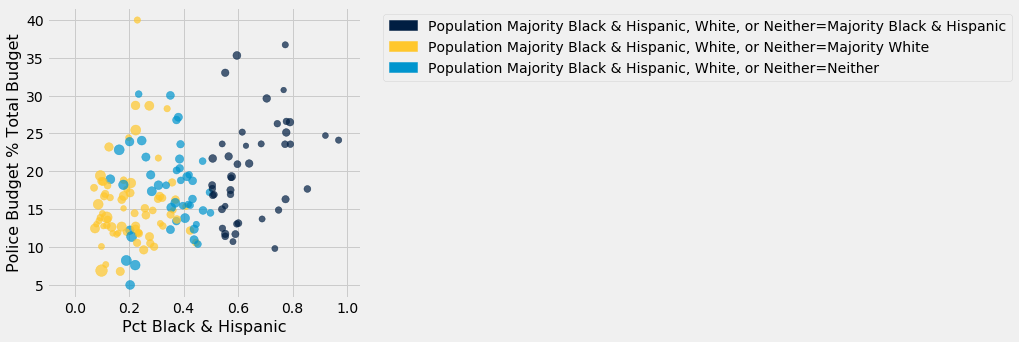

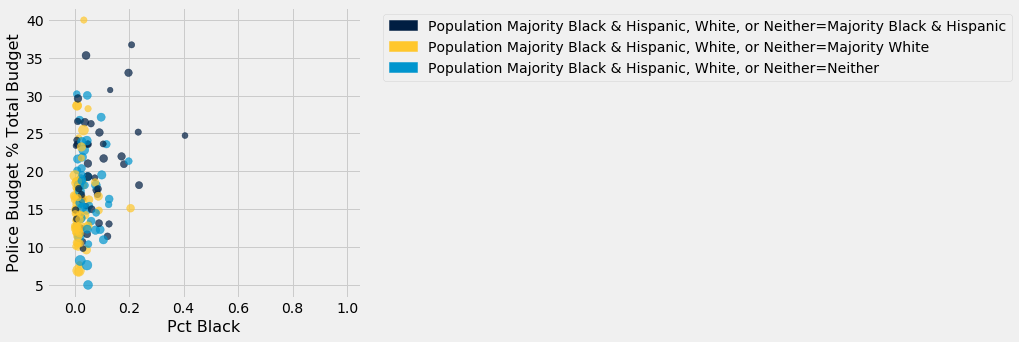

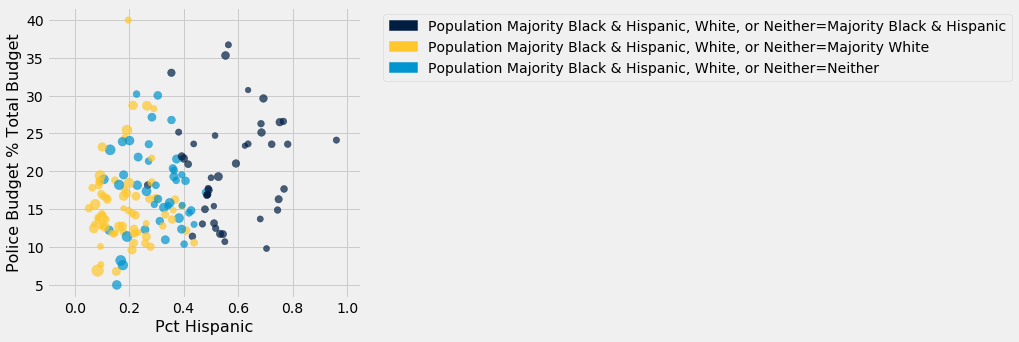

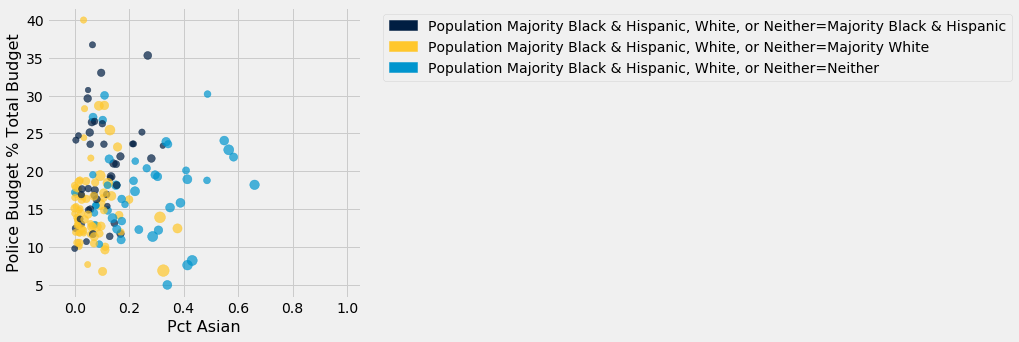

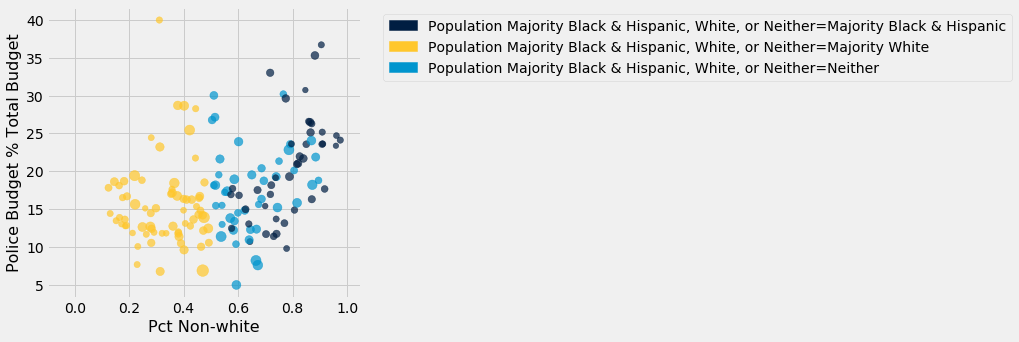

In [18]:
# Create scatterplot of police budget vs. population racial breakdown
mi = all.column('Median Income')
all.scatter('White Percent of Population', 'Police Budget % Total Budget', s = mi*.0009, colors = 'Population Majority Black & Hispanic, White, or Neither')
plt.xlabel('Pct White')
plt.xlim(-0.1, 1.05)
all.scatter('Pct Black & Hispanic', 'Police Budget % Total Budget', s = mi*.0009, colors = 'Population Majority Black & Hispanic, White, or Neither')
plt.xlim(-0.1, 1.05)
all.scatter('Black Percent of Population','Police Budget % Total Budget',  s = mi*.0009, colors = 'Population Majority Black & Hispanic, White, or Neither')
plt.xlabel('Pct Black')
plt.xlim(-0.1, 1.05)
all.scatter('Pct Hispanic', 'Police Budget % Total Budget', s = mi*.0009, colors = 'Population Majority Black & Hispanic, White, or Neither')
plt.xlim(-0.1, 1.05)
all.scatter('Pct Asian', 'Police Budget % Total Budget', s = mi*.0009, colors = 'Population Majority Black & Hispanic, White, or Neither')
plt.xlim(-0.1, 1.05)
all.scatter('Pct Non-white', 'Police Budget % Total Budget', s = mi*.0009, colors = 'Population Majority Black & Hispanic, White, or Neither')
plt.xlim(-0.1, 1.05)

**Part I: Bootstrap**

The following cells were used to run the bootstrap. The dataset includes a sample of 157 California law enforcement jurisdictions. We will use this sample and apply the bootstrap method to estimate population median (i.e., the median for all California law enforcement jurisdictions) for a police budget variable.  

In [19]:
# Produce a sample of the dataset
jurisdiction_sample = all.sample()

# Generate resamples and for each resample, calculate median police budget % total jurisdiction budget
medians = []
for i in np.arange(5000): 
    resample = jurisdiction_sample.sample()
    median = np.median(resample.column('Police Budget % Total Budget'))
    medians.append(median)

95% Confidence Interval (in magenta): [16.560, 18.482]


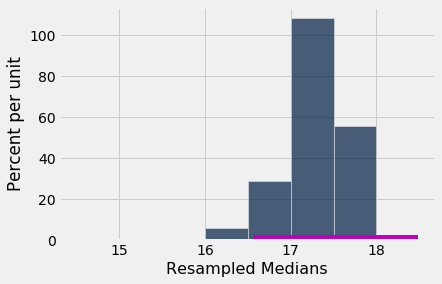

In [20]:
# Create table & histogram populated with resample median values for police budget % total jurisdiction budget
bins = np.arange(14.5, 18.5, .5)
Table().with_column('Resampled Medians', medians).hist(bins = bins)
#plt.title('Histogram of Resampled Medians')

# Generate confidence interval using distribution of resampled median values
lower_bound_95p = percentile(2.5, medians)
upper_bound_95p = percentile(97.5, medians)

# Plot confidence interval
plt.plot(make_array(lower_bound_95p, upper_bound_95p), make_array(0, 0), c = 'm', lw = 10)
print('95% Confidence Interval (in magenta): [{:.3f}, {:.3f}]'.format(lower_bound_95p, upper_bound_95p))

# Plot sample median
# samp_median = np.median(all.column('Police Budget % Total Budget'))
# plt.scatter(samp_median, -1.5, marker='^', color='c', s=100);
# print('Sample Population Median (in cyan): {:.3f}'.format(pop_median))

**Part II: Hypothesis Test**

The following cells were used to run an A/B test. 

The test aims to test the hypothesis that in jurisdictions that are majority black & hispanic, the police budget makes up a larger percentage of the full jurisdiction budget than in jurisdictions that are majority white. 

Null hypothesis: The distribution of police budgets as a percentage of total jurisdiction budgets is the same for jusdictions that are majority black and hispanic as for jurisdictions that are majority white. 
Alternative hypothesis: In jurisdictions that are majority black and hispanic, police budgets make up a larger portion of total jurisdiction budgets, on average, than in jurisdictions that are majority white. 

The test statistic used is the difference between the mean police budget as a percentage of total budget in majority black and hispanic jurisdictions vs. in majority white jurisdiction. 

Based on the resulting p-value, we reject the null hypothesis. 

In [21]:
# Create table that only includes jurisdictiona that are majority black and hispanic or majority white
# Calculate how many jurisdictions are left (to make sure there are enough for an analysis)
all_mod = all.where('Population Majority Black & Hispanic, White, or Neither', are.not_equal_to('Neither'))
all_mod.num_rows

113

In [22]:
# Remove unecessary rows, leaving only the jurisdiction name, column on pop. majority, & police budget % total budget
all_mod = all_mod.select('Population Majority Black & Hispanic, White, or Neither', 'Police Budget % Total Budget')
all_mod

"Population Majority Black & Hispanic, White, or Neither",Police Budget % Total Budget
Majority White,17.042
Majority White,18.8519
Majority Black & Hispanic,11.7905
Majority Black & Hispanic,32.9937
Majority Black & Hispanic,17.5547
Majority White,16.2949
Majority White,15.6823
Majority White,10.0942
Majority White,11.7308
Majority White,13.6876


In [23]:
# Simulate the test statistic under the null hypothesis

differences = []
num_sims = 5000

for i in np.arange(num_sims):
    # Create shuffled list of police budget values
    shuffled = all_mod.drop(0).sample(with_replacement = False)[0]
    # Add shuffled values to table w/ unshuffled values
    all_mod_wshuffle = all_mod.with_column('Shuffled', shuffled)
    # For each population majority category, calculate average of shuffled values
    shuff_avg = all_mod_wshuffle.group(0, np.average)[2]
    # Calculate difference between the two groups' shuffled averages
    difference = shuff_avg[0] - shuff_avg[1]
    # Add difference to list of differences
    differences.append(difference)

p-value (in cyan): 0.000200000000000
0.0002


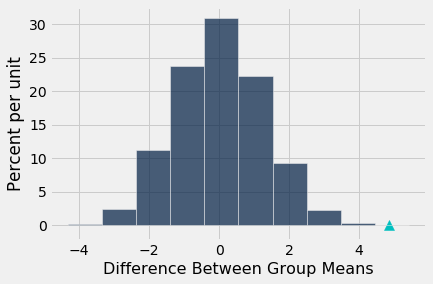

In [24]:
# Generate histogram of simulated differences
Table().with_column('Difference Between Group Means', differences).hist()
#plt.title('Prediction Under Null Hypothesis')

# Calculate observed difference between the two groups 
#(i.e., observed difference between police budget as a % of total budget in majority white vs. majority black & hispanic jurisdictions)
observed_difference = all_mod.group(0, np.average)[1][0]-all_mod.group(0, np.average)[1][1]

# Plot observed difference on histogram
plt.scatter(observed_difference, 0, marker='^', color='c', s=100);

# Calculate p-value
p_value = np.count_nonzero(differences >= observed_difference)/num_sims
print('p-value (in cyan): {:.15f}'.format(p_value))
print(p_value)

**Additional data exploration**

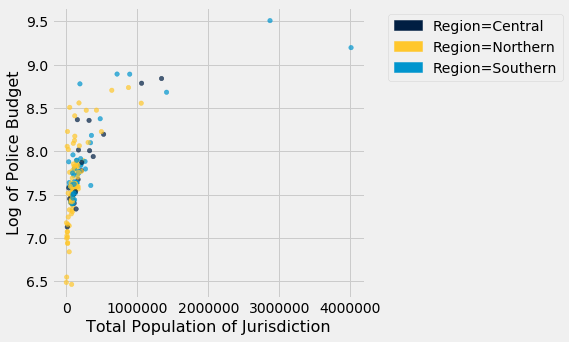

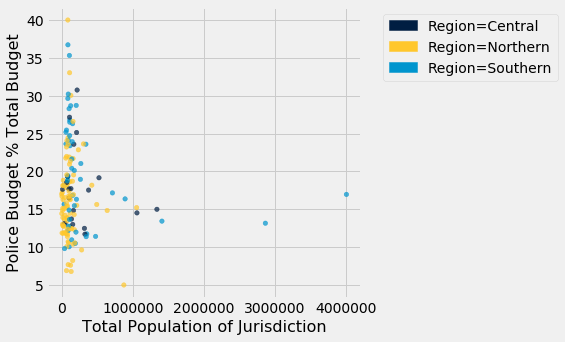

In [25]:
# Create scatterplot of population vs. log police budget, coded by region
all.scatter('Total Population of Jurisdiction', 'Log of Police Budget', colors = 'Region')
# Create scatterplot of population vs. police budget % total budget, coded by region
all.scatter('Total Population of Jurisdiction', 'Police Budget % Total Budget', colors = 'Region')


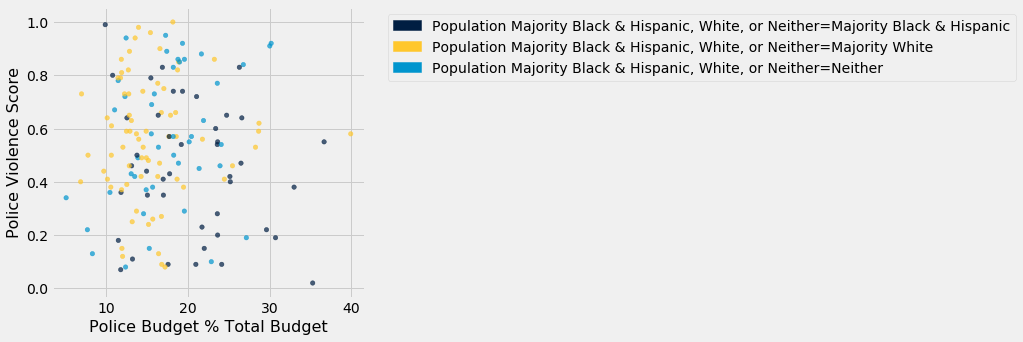

In [26]:
# Create scatterplot of police budget vs. police scores
all.scatter('Police Budget % Total Budget', 'Police Violence Score', colors = 'Population Majority Black & Hispanic, White, or Neither')


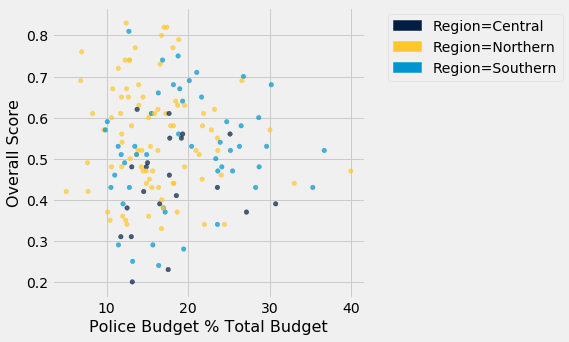

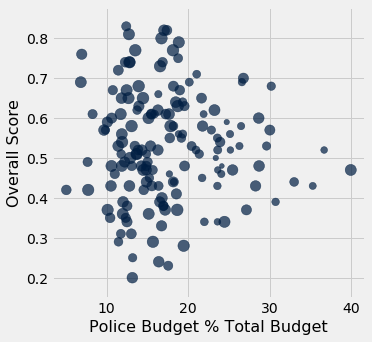

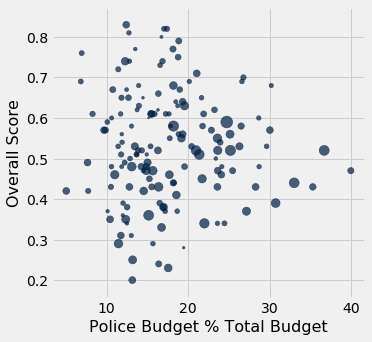

In [27]:
# Create scatterplot of police budget vs. police scores
all.scatter('Police Budget % Total Budget', 'Overall Score', colors = 'Region')
all.scatter('Police Budget % Total Budget', 'Overall Score', sizes = 'White Percent of Population', s = 70)
all.scatter('Police Budget % Total Budget', 'Overall Score', sizes = 'Black Percent of Population', s = 70)

(0, 0.0004)

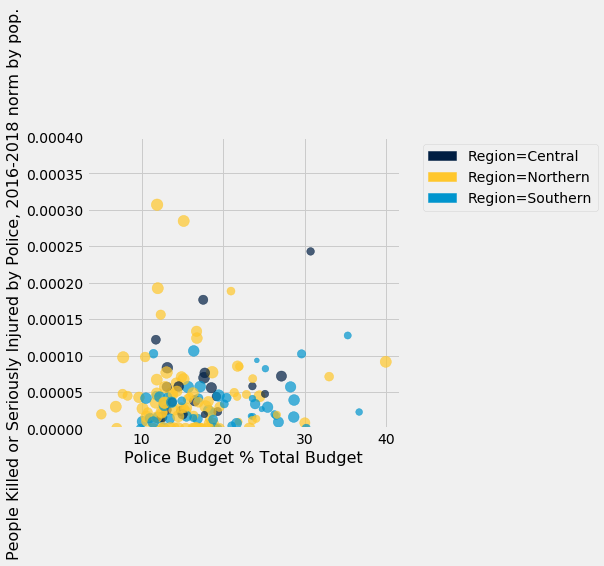

In [ ]:
# Create scatterplot of population vs. police budget % total budget, coded by region
all.scatter('Police Budget % Total Budget', 'People Killed or Seriously Injured by Police, 2016-2018 norm by pop.', 
            colors = 'Region',sizes = 'White Percent of Population', s = 70)
plt.ylim(0, 0.0004)
all.scatter('Police Budget % Total Budget', 'People Killed or Seriously Injured by Police, 2016-2018 norm by pop.', 
            sizes = 'White Percent of Population', s = 70)
plt.ylim(0, 0.0004)